In [1]:
import pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import random
from scipy import stats
from math import ceil

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
def normalizeData():
    global trainIn
    global trainOut
    global valIn
    global valOut
    
    normInfo=[]
    trainOutput=np.log(trainOut[:,1])
    valOutput=np.log(valOut[:,1])
    fullData=trainOutput.tolist()+valOutput.tolist()
    mean, sd = stats.norm.fit(fullData)
    
    trainOutput-=mean
    trainOutput/=sd

    
    valOutput-=mean
    valOutput/=sd
    X=np.linspace(-3,3,1000)
    #plt.figure(0)
    #plt.plot(X, stats.norm.pdf(X, 0, 1))
    #plt.hist(trainOutput,bins=100,density=True)
    
    
    normInfo.append((mean,sd))
    for x in range(len(trainIn[1,:])):
        minVal=min(np.amin(trainIn[:,x]),np.amin(valIn[:,x]))
        maxVal=max(np.amax(trainIn[:,x]),np.amax(valIn[:,x]))           
        trainIn[:,x]=(trainIn[:,x]-minVal)*2/(maxVal-minVal)-1
        valIn[:,x]=(valIn[:,x]-minVal)*2/(maxVal-minVal)-1
        normInfo.append((minVal,maxVal))
        #plt.figure(x+1)
        #plt.hist(trainIn[:,x])
    data=[trainIn,trainOutput,valIn,valOutput]
    return(normInfo,data)
    """ 
    X=np.linspace(-3,3,1000)
    a=plt.figure(0)
    plt.plot(X, stats.norm.pdf(X, 0, 1))
    plt.hist(trainOutput,bins=100,density=True)
    plt.savefig("Normalized NLO Training")

    b=plt.figure(1)
    plt.plot(X, stats.norm.pdf(X, 0, 1))
    plt.hist(valOutput,bins=100,density=True)
    plt.savefig("Normalized NLO Validation")
    """
def build_input_pipeline(data, batch_size, heldout_size):
    """Build an Iterator switching between train and heldout data."""
    # Build an iterator over training batches.
  
  
    training_dataset = tf.data.Dataset.from_tensor_slices(
                    (data[0].astype(np.float32), data[1].astype(np.float32)))
  
    training_batches = training_dataset.shuffle(
                    50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
    training_iterator = training_batches.make_one_shot_iterator()
    # Build a iterator over the heldout set with batch_size=heldout_size,
    # i.e., return the entire heldout set as a constant.
    heldout_dataset = tf.data.Dataset.from_tensor_slices((data[2].astype(np.float32), data[3].astype(np.float32)))
    heldout_frozen = (heldout_dataset.take(heldout_size).
                    repeat().batch(heldout_size))
    heldout_iterator = heldout_frozen.make_one_shot_iterator()

    prediction_dataset = tf.data.Dataset.from_tensor_slices(
                    (data[2][0:10,:].astype(np.float32), data[3][0:10].astype(np.float32)))
    prediction_frozen = (prediction_dataset.take(heldout_size).
                    repeat().batch(heldout_size))
    prediction_iterator = prediction_frozen.make_one_shot_iterator()
    
    # Combine these into a feedable iterator that can switch between training
    # and validation inputs.
    handle = tf.placeholder(tf.string, shape=[])
    #print(training_batches.output_types)
    feedable_iterator = tf.data.Iterator.from_string_handle(
        handle, training_batches.output_types, training_batches.output_shapes)
    x_input, y_output = feedable_iterator.get_next()
    return x_input, y_output, handle, training_iterator, heldout_iterator, prediction_iterator

/home/kronheim/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/kronheim/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/kronheim/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/kronheim/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/kronheim/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: D


Epoch:   1 Training loss: 0.638 Training Error: 258.456
Validation loss: 0.359 Validation Error: 392.378 Iteration: 5
Predicted: 0.0003571 Lower 95%: 0.0000392 Higher 95%: 0.0032550 Actual: 1.3400000
Predicted: 0.0048844 Lower 95%: 0.0003318 Higher 95%: 0.0719117 Actual: 0.0062000
Predicted: 0.4236368 Lower 95%: 0.1140292 Higher 95%: 1.5738793 Actual: 0.5530000
Predicted: 0.0000155 Lower 95%: 0.0000007 Higher 95%: 0.0003650 Actual: 0.0000067
Predicted: 0.0129832 Lower 95%: 0.0016107 Higher 95%: 0.1046508 Actual: 0.0055900

Epoch:   2 Training loss: 0.250 Training Error: 262.519
Validation loss: 0.160 Validation Error: 291.522 Iteration: 5
Predicted: 0.0456349 Lower 95%: 0.0041560 Higher 95%: 0.5010993 Actual: 1.3400000
Predicted: 0.0047824 Lower 95%: 0.0002698 Higher 95%: 0.0847715 Actual: 0.0062000
Predicted: 0.4074169 Lower 95%: 0.0953797 Higher 95%: 1.7402921 Actual: 0.5530000
Predicted: 0.0000039 Lower 95%: 0.0000001 Higher 95%: 0.0001142 Actual: 0.0000067
Predicted: 0.0053669 Low


Epoch:  17 Training loss: 0.016 Training Error: 58.525
Validation loss: 0.016 Validation Error: 74.920 Iteration: 5
Predicted: 0.6960066 Lower 95%: 0.2986205 Higher 95%: 1.6222098 Actual: 1.3400000
Predicted: 0.0057996 Lower 95%: 0.0030235 Higher 95%: 0.0111249 Actual: 0.0062000
Predicted: 1.2677484 Lower 95%: 0.7619573 Higher 95%: 2.1092863 Actual: 0.5530000
Predicted: 0.0000053 Lower 95%: 0.0000021 Higher 95%: 0.0000130 Actual: 0.0000067
Predicted: 0.0046362 Lower 95%: 0.0026945 Higher 95%: 0.0079771 Actual: 0.0055900

Epoch:  18 Training loss: 0.015 Training Error: 66.045
Validation loss: 0.013 Validation Error: 64.694 Iteration: 5
Predicted: 0.7797251 Lower 95%: 0.3497950 Higher 95%: 1.7380788 Actual: 1.3400000
Predicted: 0.0059413 Lower 95%: 0.0030175 Higher 95%: 0.0116983 Actual: 0.0062000
Predicted: 1.2823190 Lower 95%: 0.7199191 Higher 95%: 2.2840651 Actual: 0.5530000
Predicted: 0.0000045 Lower 95%: 0.0000021 Higher 95%: 0.0000099 Actual: 0.0000067
Predicted: 0.0044726 Lower 9

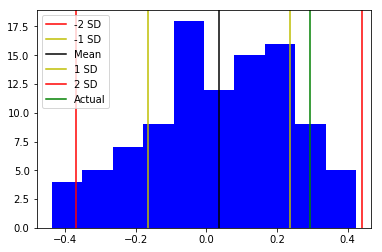

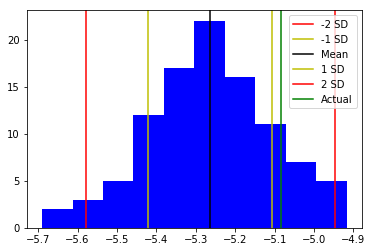

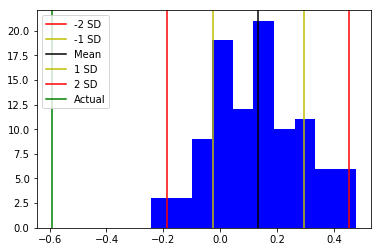

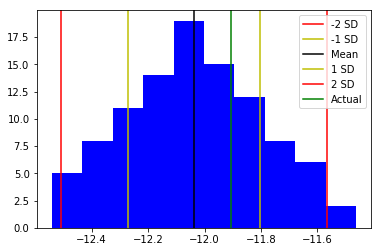

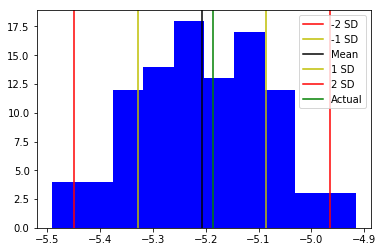

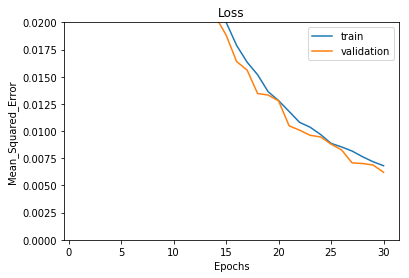

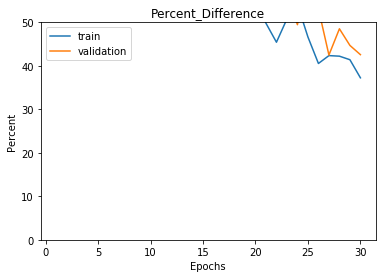

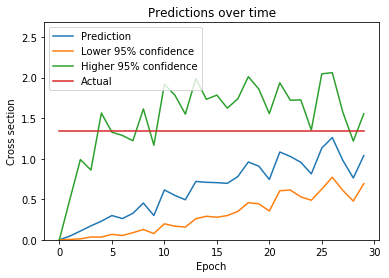

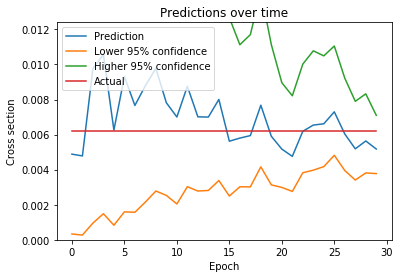

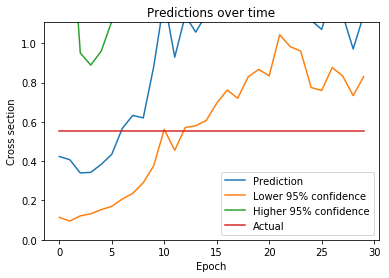

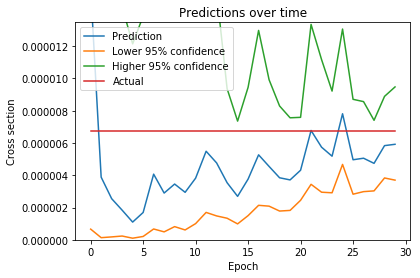

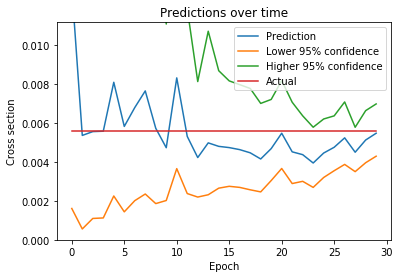

In [3]:
trainIn=np.loadtxt("fullTrainInput.txt",delimiter="\t",skiprows=1)
trainOut=np.loadtxt("fullTrainOutput.txt",delimiter="\t",skiprows=1)
valIn=np.loadtxt("fullValidateInput.txt",delimiter="\t",skiprows=0)
valOut=np.loadtxt("fullValidateOutput.txt",delimiter="\t",skiprows=0)

tfd = tfp.distributions
batch_size=128
learning_rate=0.001
train_size=len(trainIn[:,1])
val_size=len(trainOut[:,1])
data_size=train_size+val_size

normInfo, data = normalizeData()
#create the input pipeline
(x_input, y_output, handle,
   training_iterator, heldout_iterator, prediction_iterator) = build_input_pipeline(
       data, batch_size, val_size)
#create the neural network
with tf.name_scope("bayesian_neural_net", values=[x_input]):
    neural_net = tf.keras.Sequential([
        #tf.keras.layers.BatchNormalization(),
        tfp.layers.DenseFlipout(75, activation=tf.nn.leaky_relu,input_shape=x_input.shape),
        tfp.layers.DenseFlipout(75, activation=tf.nn.leaky_relu),
        tfp.layers.DenseFlipout(1, activation=None)])

    logits = neural_net(x_input) 

# Build metrics for evaluation. Predictions are formed from a single forward
# pass of the probabilistic layers. They are cheap but noisy predictions.


percentDifference = tf.reduce_mean(abs((y_output-tf.reduce_sum(logits,axis=-1))*100/(y_output)))
loss=tf.losses.mean_squared_error(labels=y_output, predictions=tf.reduce_sum(logits,axis=-1))

#add the optimizer and loss
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)

#initialization operator
init_op= tf.group(tf.global_variables_initializer(),
                     tf.local_variables_initializer())

#run the training 
epochs = 30
with tf.Session() as sess:
    #STORE_PATH=os.getcwd()
    #writer = tf.summary.FileWriter(STORE_PATH, sess.graph)
    sess.run(init_op)

    train_handle = sess.run(training_iterator.string_handle())
    validate_handle = sess.run(heldout_iterator.string_handle())
    prediction_handle = sess.run(prediction_iterator.string_handle())
    steps=ceil(train_size/batch_size)
    trainLoss=[]
    trainErrors=[]
    valLoss=[]
    valErrors=[]
    prediction_iters=100
    prediction_number=5
    guesses=np.zeros((prediction_number, epochs))
    low95=np.zeros((prediction_number, epochs))
    high95=np.zeros((prediction_number, epochs))
    actual=np.zeros((prediction_number, epochs))
    X=np.linspace(1,epochs,epochs)
    

    points=[]
    maxLen=len(data[3])
    #for x in range(prediction_number):
    #    points.append(random.randint(0,len(data[3])))
    points=[0,int(maxLen*.25),int(maxLen*.50),int(maxLen*.75),maxLen-1]
    
    predictions=np.zeros((prediction_number,prediction_iters))
    for j in range(epochs):
        averageLoss=0
        averageError=0
        
        for i in range(steps):
            loss_value, error_value, _ = sess.run([loss, percentDifference, train_op],
                       feed_dict={handle: train_handle})
            
            averageLoss+=loss_value
            averageError+=abs(error_value)
            
            
        print()    
        trainLoss.append(averageLoss/steps)
        trainErrors.append(averageError/steps)
        
        
        #now setup the validation run
        valid_iters=5
        #re-initialize the iterator, but this time with validation data
        averageLoss=0
        averageError=0
        
        for i in range(valid_iters):
            loss_value, error_value = sess.run([loss, percentDifference],
                                 feed_dict={handle: validate_handle})
            averageLoss+=loss_value
            averageError+=abs(error_value)
        
        
        valLoss.append(averageLoss/valid_iters)
        valErrors.append(averageError/valid_iters)
        print("Validation loss: {:.3f} Validation Error: {:.3f} Iteration: {}".format(
                averageLoss/valid_iters, averageError/valid_iters, valid_iters))
        if((j+1)%1==0):
            #now setup the final predictions


            for i in range(prediction_iters):
                for k in range(prediction_number):
                    predictions[k,i]=neural_net.predict(data[2][points[k]].reshape((1,1,19)))

    
    
            predictions = predictions*normInfo[0][1]+normInfo[0][0]
            #predictions=np.exp(predictions)
            
            for i in range(prediction_number):
                point=data[3][points[i]]*normInfo[0][1]+normInfo[0][0]
                #point=np.exp(point)
                sd=np.std(predictions[i,:])
                mean=np.mean(predictions[i,:])
                if(j+1==epochs):
                    plt.figure(i)
                    plt.hist(predictions[i,:],color="b")

                    plt.axvline(x=mean-sd*2,color="r")
                    plt.axvline(x=mean-sd*1,color="y")
                    plt.axvline(x=mean,color="k")
                    plt.axvline(x=mean+sd*1,color="y")
                    plt.axvline(x=mean+sd*2,color="r")
                    plt.axvline(x=point,color="g")
                    plt.legend(["-2 SD", "-1 SD", "Mean", "1 SD", "2 SD", "Actual"])
                
                guesses[i, j]=np.exp(mean)
                low95[i, j]=np.exp(mean-sd*2)
                high95[i, j]=np.exp(mean+sd*2)
                actual[i, j]=np.exp(point)
                print("Predicted: {:.7f} Lower 95%: {:.7f} Higher 95%: {:.7f} Actual: {:.7f}".format(
                        np.exp(mean), np.exp(mean-sd*2), np.exp(mean+sd*2), np.exp(point)))

    #valLoss.append(averageLoss/valid_iters)
    #valErrors.append(averageError/valid_iters)
    #print("Validation loss: {:.3f} Validation Error: {:.3f} Iteration: {}".format(
            #averageLoss, averageError, valid_iters))

    
    
    plt.figure(11)
    plt.plot(X,trainLoss)
    plt.plot(X,valLoss)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Mean_Squared_Error")
    plt.ylim(0,0.02)
    plt.legend(["train","validation"])
    
    plt.figure(12)
    plt.plot(X,trainErrors)
    plt.plot(X,valErrors)
    plt.title("Percent_Difference")
    plt.xlabel("Epochs")
    plt.ylabel("Percent")
    plt.ylim(0,50)
    plt.legend(["train","validation"])
    
    for x in range(int(prediction_number)):
        plt.figure(15+x)
        plt.plot(guesses[x,:])
        plt.plot(low95[x,:])
        plt.plot(high95[x,:])
        plt.plot(actual[x,:])
        plt.title("Predictions over time")
        plt.xlabel("Epoch")
        plt.ylabel("Cross section")
        plt.ylim(0,2*actual[x,0])
        plt.legend(["Prediction","Lower 95% confidence", "Higher 95% confidence", "Actual"])
    

In [4]:
"""
with tf.Session() as sess:
    sess.run(init_op)
    prediction_iters=100
    wrong=[]
    sd3=[]
    sd2=[]
    sd1=[]
    check=int(len(data[2])/10)
    decile=0
    for k in range(len(data[2])):
        predictions=np.zeros(prediction_iters)
        for i in range(prediction_iters):
            predictions[i]=neural_net.predict(data[2][k].reshape((1,1,19)))
        point=data[3][k]*normInfo[0][1]+normInfo[0][0]
    
        
        sd=np.std(predictions)
        mean=np.mean(predictions)
        guess=np.exp(mean)
        

        low99=np.exp(mean-sd*3)
        low95=np.exp(mean-sd*2)
        low68=np.exp(mean-sd)
        high68=np.exp(mean+sd)
        high95=np.exp(mean+sd*2)
        high99=np.exp(mean+sd*3)
        actual=np.exp(point)
        if(actual<low99 or actual>high99):
            wrong.append(k)
        elif(actual<low95):
            sd3.append(k)
        elif(actual<low68):
            sd2.append(k)
        elif(actual<high68):
            sd1.append(k)
        elif(actual<high95):
            sd2.append(k)
        elif(actual<=high99):
            sd3.append(k)
        if(k%check==0):
            print(str(decile)+" Percent Complete")
            decile+=10
"""        

'\nwith tf.Session() as sess:\n    sess.run(init_op)\n    prediction_iters=100\n    wrong=[]\n    sd3=[]\n    sd2=[]\n    sd1=[]\n    check=int(len(data[2])/10)\n    decile=0\n    for k in range(len(data[2])):\n        predictions=np.zeros(prediction_iters)\n        for i in range(prediction_iters):\n            predictions[i]=neural_net.predict(data[2][k].reshape((1,1,19)))\n        point=data[3][k]*normInfo[0][1]+normInfo[0][0]\n    \n        \n        sd=np.std(predictions)\n        mean=np.mean(predictions)\n        guess=np.exp(mean)\n        \n\n        low99=np.exp(mean-sd*3)\n        low95=np.exp(mean-sd*2)\n        low68=np.exp(mean-sd)\n        high68=np.exp(mean+sd)\n        high95=np.exp(mean+sd*2)\n        high99=np.exp(mean+sd*3)\n        actual=np.exp(point)\n        if(actual<low99 or actual>high99):\n            wrong.append(k)\n        elif(actual<low95):\n            sd3.append(k)\n        elif(actual<low68):\n            sd2.append(k)\n        elif(actual<high68):\n

In [5]:
print(len(wrong))
print(len(sd3))

NameError: name 'wrong' is not defined